In [ ]:
# WOKE AND COOL DATA FORMATTING THAT SHOULD WORK ON ALL NWB DATA??

In [12]:
import glob
import pynwb
from hdmf_zarr import NWBZarrIO
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# Determine filepath to our data asset
nwb_files = glob.glob('../data/**/nwb/**.nwb')

# Load the NWB file
with NWBZarrIO(path=nwb_files[0], mode="r") as io:
    nwb = io.read()

In [14]:
import numpy as np
from pynwb import TimeSeries

def convert_events_to_binary(event_times, event_data, reference_time):
    """
    Convert event timestamps to a binary time series.
    
    Parameters:
    -----------
    event_times : array-like
        Array of event timestamps
    event_data : array-like
        Array of event data (1's for licks, 'earned' for rewards)
    reference_time : array-like
        Reference time points for the binary series
    
    Returns:
    --------
    binary_series : np.ndarray
        Binary time series where 1 indicates event occurrence
    """
    binary_series = np.zeros_like(reference_time)
    
    for t, d in zip(event_times, event_data):
        # For lick events (1's) or reward events ('earned')
        if (isinstance(d, (int, float)) and d == 1) or (isinstance(d, str) and d == 'earned'):
            idx = np.searchsorted(reference_time, t)
            if idx < len(reference_time):
                binary_series[idx] = 1
    
    return binary_series

def prepare_lds_data(nwb, observation_signals, event_signals, standardize=True, verbose=True):
    """
    Process NWB timeseries data into observation (dF/F) and input (events) matrices.
    
    Parameters:
    -----------
    nwb : NWBFile
        The NWB file containing the timeseries data
    observation_signals : list
        List of dF/F signals to use as observations (e.g., ['G_1_dff-poly'])
    event_signals : list
        List of event signals to use as inputs (e.g., ['left_lick_time'])
    standardize : bool, default=True
        Whether to z-score standardize the dF/F signals
    verbose : bool, default=True
        Whether to print debugging information
        
    Returns:
    --------
    lds_data : dict
        Dictionary containing processed matrices
    """
    # Process observation channels (dF/F signals)
    observations = []
    valid_obs_names = []
    
    # Use the first observation signal's timestamps as reference
    ref_signal = nwb.acquisition[observation_signals[0]]
    ref_time = ref_signal.timestamps[:]
    
    for key in observation_signals:
        try:
            ts = nwb.acquisition[key]
            data = ts.data[:]
            
            # Ensure 2D array
            if data.ndim == 1:
                data = data.reshape(-1, 1)
            
            if standardize:
                # Z-score standardize
                data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
            
            observations.append(data)
            valid_obs_names.append(key)
            
            if verbose:
                print(f"Processed observation {key}: shape {data.shape}")
                
        except Exception as e:
            print(f"Skipping observation {key}: {str(e)}")
    
    # Process event channels
    inputs = []
    valid_input_names = []
    
    for key in event_signals:
        try:
            ts = nwb.acquisition[key]
            event_times = ts.timestamps[:]
            event_data = ts.data[:]
            
            # Convert to binary series
            binary_series = convert_events_to_binary(event_times, event_data, ref_time)
            inputs.append(binary_series.reshape(-1, 1))
            valid_input_names.append(key)
            
            if verbose:
                n_events = np.sum(binary_series)
                print(f"\nProcessed {key}:")
                print(f"Number of events: {n_events}")
                
        except Exception as e:
            print(f"Skipping input {key}: {str(e)}")
    
    # Combine into matrices
    Y = np.hstack(observations) if observations else np.array([])
    U = np.hstack(inputs) if inputs else np.array([])
    
    return {
        'observations': Y,  # Y matrix for LDS (dF/F signals)
        'inputs': U,       # U matrix for LDS (binary event series)
        'time': ref_time,
        'observation_names': valid_obs_names,
        'input_names': valid_input_names,
        'sampling_rate': 1.0 / np.mean(np.diff(ref_time))
    }

In [15]:
# Define which channels are observations vs inputs
observation_keys = ['G_1_dff-poly']  # Neural activity as observations
input_keys = ['left_lick_time', 'right_lick_time', 'left_reward_delivery_time', 'right_reward_delivery_time']

# Process the data
lds_data = prepare_lds_data(nwb, observation_keys, input_keys)

# Access the processed matrices
Y = lds_data['observations']  # Observation matrix (time x n_observations)
U = lds_data['inputs']       # Input matrix (time x n_inputs)
T = lds_data['time']       # Input matrix (time x n_inputs)

print(f"Observations shape: {Y.shape}")
print(f"Inputs shape: {U.shape}")

Processed observation G_1_dff-poly: shape (120400, 1)

Processed left_lick_time:
Number of events: 2234.0

Processed right_lick_time:
Number of events: 1840.0

Processed left_reward_delivery_time:
Number of events: 77.0

Processed right_reward_delivery_time:
Number of events: 105.0
Observations shape: (120400, 1)
Inputs shape: (120400, 4)


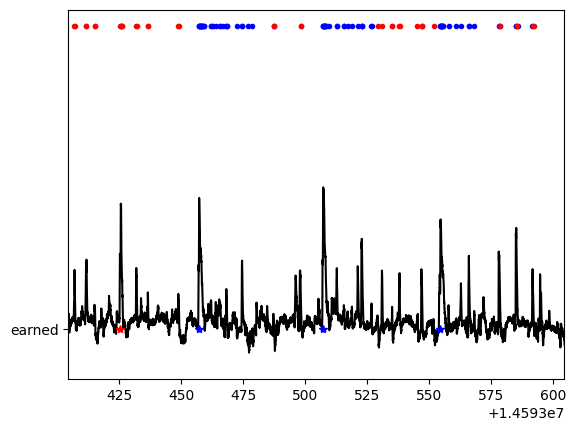

In [25]:
plt.close()
T_inds = [T[100000],T[104000]]# [T[0],T[-1]]#

plt.plot(nwb.acquisition['G_1_dff-poly'].timestamps[:], nwb.acquisition['G_1_dff-poly'].data[:],'-k') # observations
plt.plot(nwb.acquisition['left_lick_time'].timestamps[:], nwb.acquisition['left_lick_time'].data[:],'.b') # binary 1 during lick (input)
plt.plot(nwb.acquisition['right_lick_time'].timestamps[:], nwb.acquisition['right_lick_time'].data[:],'.r')# binary 1 during lick (input)
plt.plot(nwb.acquisition['left_reward_delivery_time'].timestamps[:], nwb.acquisition['left_reward_delivery_time'].data[:],'*b') # 'earned' during reward event (input)
plt.plot(nwb.acquisition['right_reward_delivery_time'].timestamps[:], nwb.acquisition['right_reward_delivery_time'].data[:],'*r')# 'earned' during reward event (input)

plt.xlim(T_inds)
plt.show()

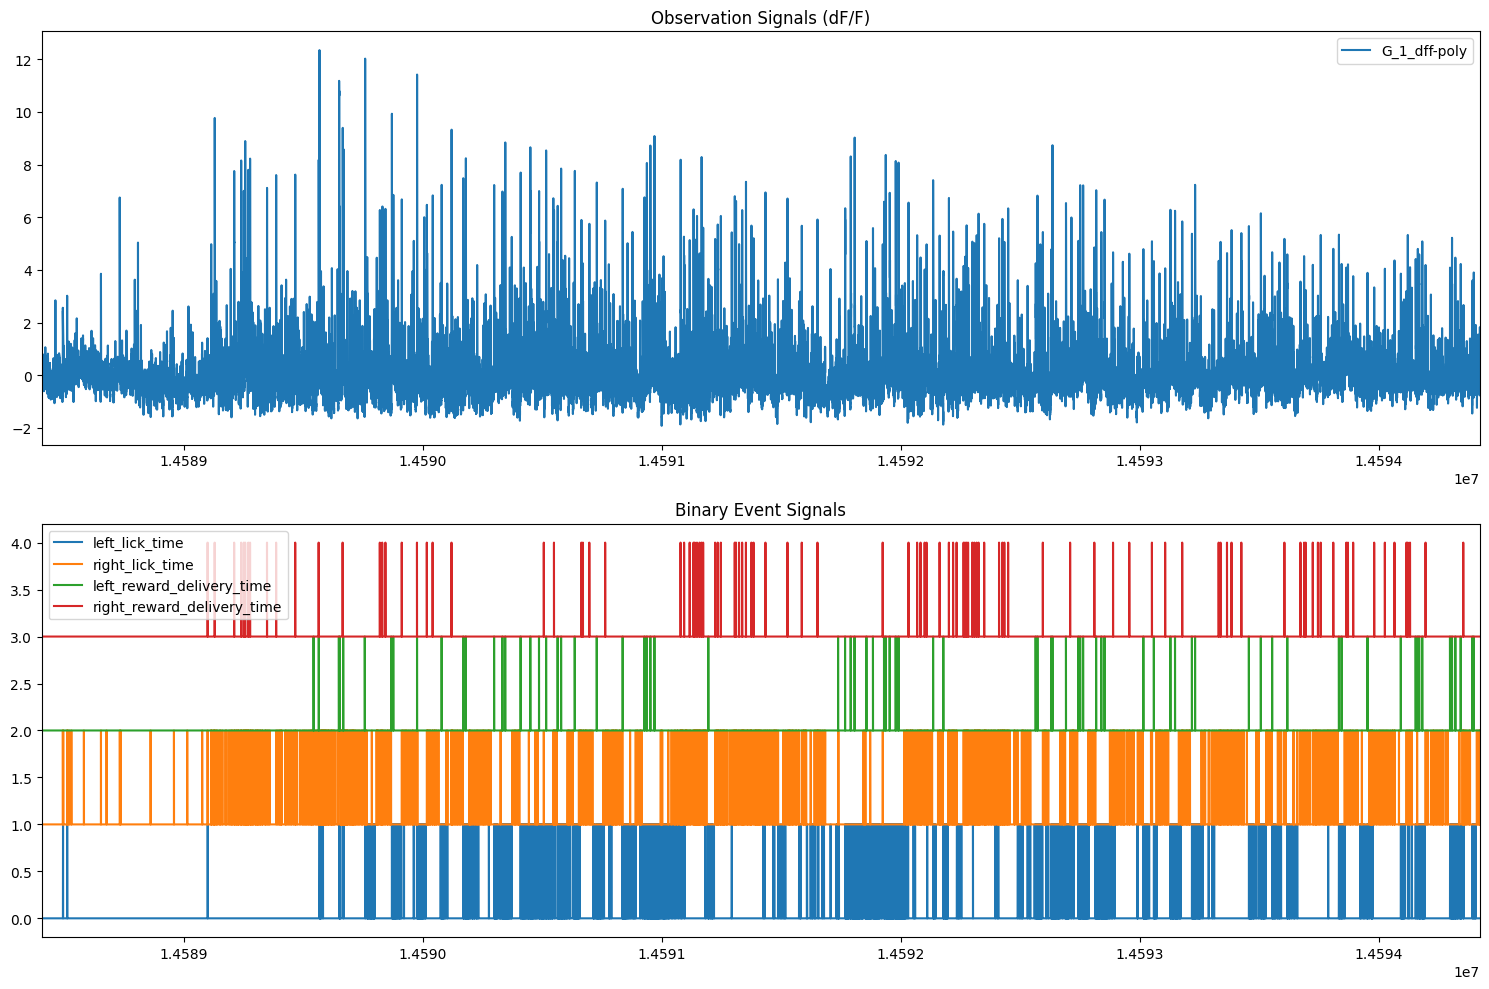

In [24]:
# Visualize the processed data

plt.figure(figsize=(15, 10))

# Plot observations
plt.subplot(211)
for i, name in enumerate(lds_data['observation_names']):
    plt.plot(lds_data['time'], Y[:, i], label=name)
plt.title('Observation Signals (dF/F)')
plt.legend()
plt.xlim(T_inds)

# Plot binary event signals
plt.subplot(212)
for i, name in enumerate(lds_data['input_names']):
    # Offset each signal for visibility
    plt.plot(lds_data['time'], U[:, i] + i, label=name)
plt.title('Binary Event Signals')
plt.legend()
plt.xlim(T_inds)
plt.tight_layout()
plt.show()